# Example of Calibration

Import stuff

In [1]:
# Default

budget = 8192
num_workers = 256
maximum_jobs = 64

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dask.distributed import Client
from dask_jobqueue import SLURMCluster as Cluster

import nevergrad as ng
from mhpc_project.matsch_b2 import CalibrationModel, Variables, Loss, NGO
from geotopy.utils import date_parser, comparison_plot, ProgressBar, ParametersLogger
from geotopy.measures import KGE

Load observations and apply some filters

In [3]:
observations = pd.read_csv('../data/Matsch B2/observations/obs.csv',
                           na_values=['-9999', '-99.99'],
                           usecols=[0, 7],
                           parse_dates=[0],
                           date_parser=date_parser,
                           index_col=0,
                           squeeze=True)
observations.index.rename('datetime', inplace=True)

selection = observations.index.map(lambda x: not (x < date_parser('01/03/2011 23:00') or x.month in [12,1,2]))

observations = observations[selection]

Load observations, model, loss function and calibration strategy

In [4]:
model = CalibrationModel('../data/Matsch B2/geotop', run_args={'timeout': 180})
variables = Variables('../data/Matsch B2/variables/soil.csv')
measure = KGE(observations)
loss = Loss(model, variables, measure)
calibration = NGO(loss, budget=budget, num_workers=num_workers)

Evaluate the model and plot the risults

Before optimization loss is 1.1325617232229777


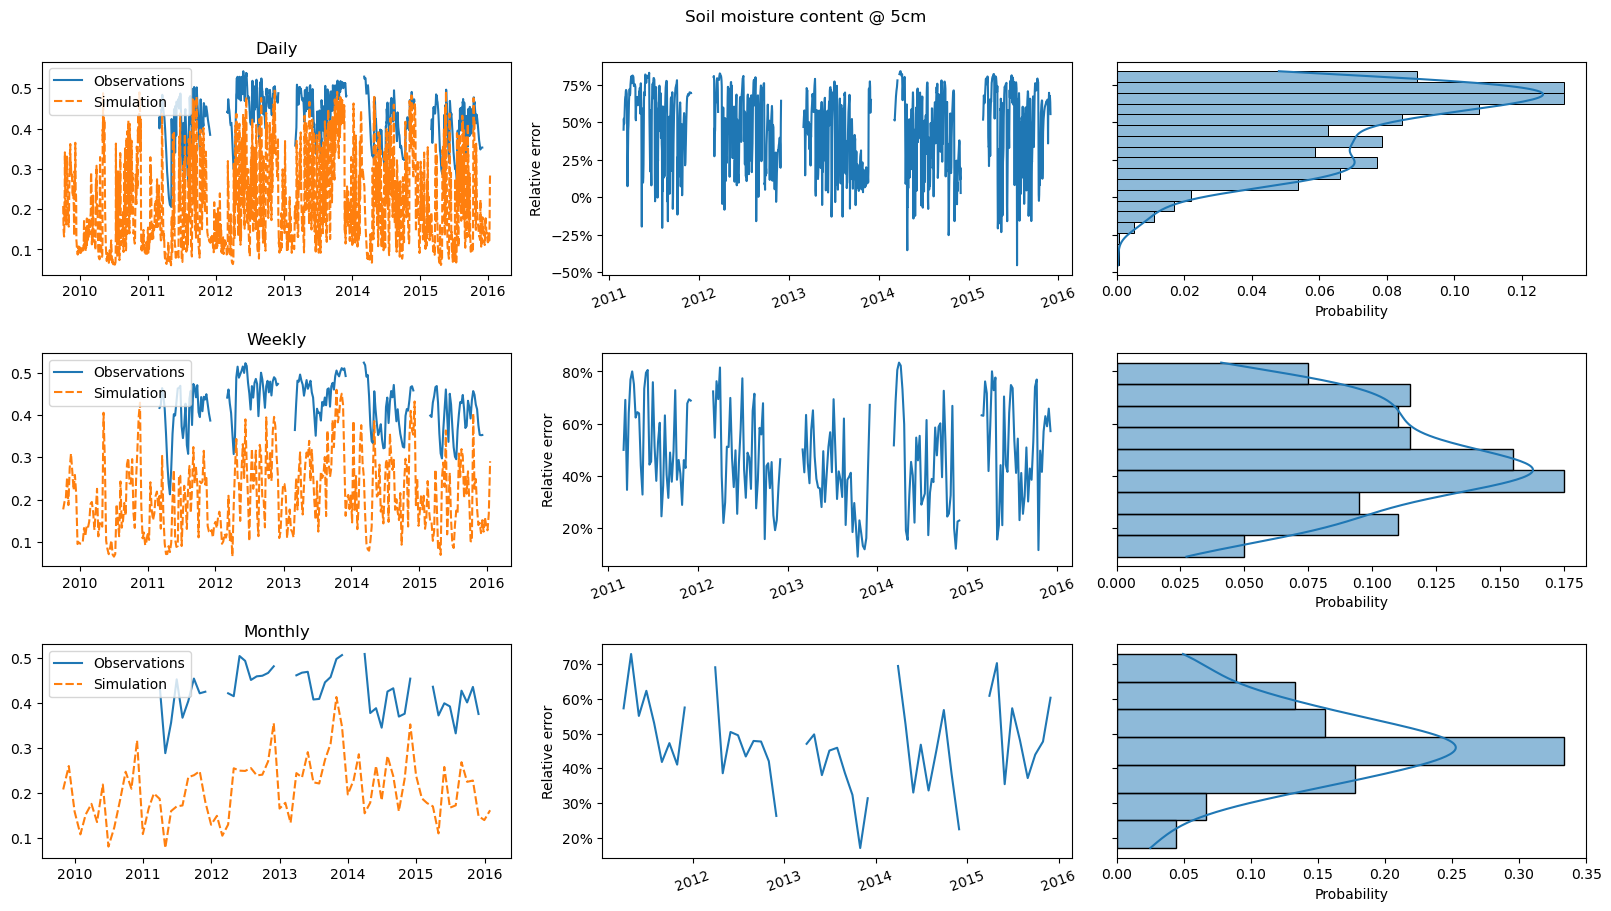

In [5]:
simulation = model()
print(f"Before optimization loss is {measure(simulation)}")
comparison_plot(observations,
                simulation,
                desc='Soil moisture content @ 5cm',
                rel=True)
plt.show()

Launch Dask cluster using `dask-jobqueue`

In [6]:
cluster = Cluster()
cluster.adapt(maximum_jobs=maximum_jobs)

client = Client(cluster)

Run calibration

In [7]:
logger = ParametersLogger(loss.massage)

calibration.optimizer.register_callback('tell', logger)

calibration.optimizer.register_callback('tell', ProgressBar(total=calibration.optimizer.budget))

with warnings.catch_warnings():
    
    warnings.simplefilter("ignore")
    recommendation = calibration(executor=client)

(128_w,256)-aCMA-ES (mu_w=66.9,w_1=3%) in dimension 9 (seed=<module 'time' (built-in)>, Wed Nov 25 14:17:57 2020)


Plot results and show table of calibrated values

After optimization loss is 0.3433450442413575


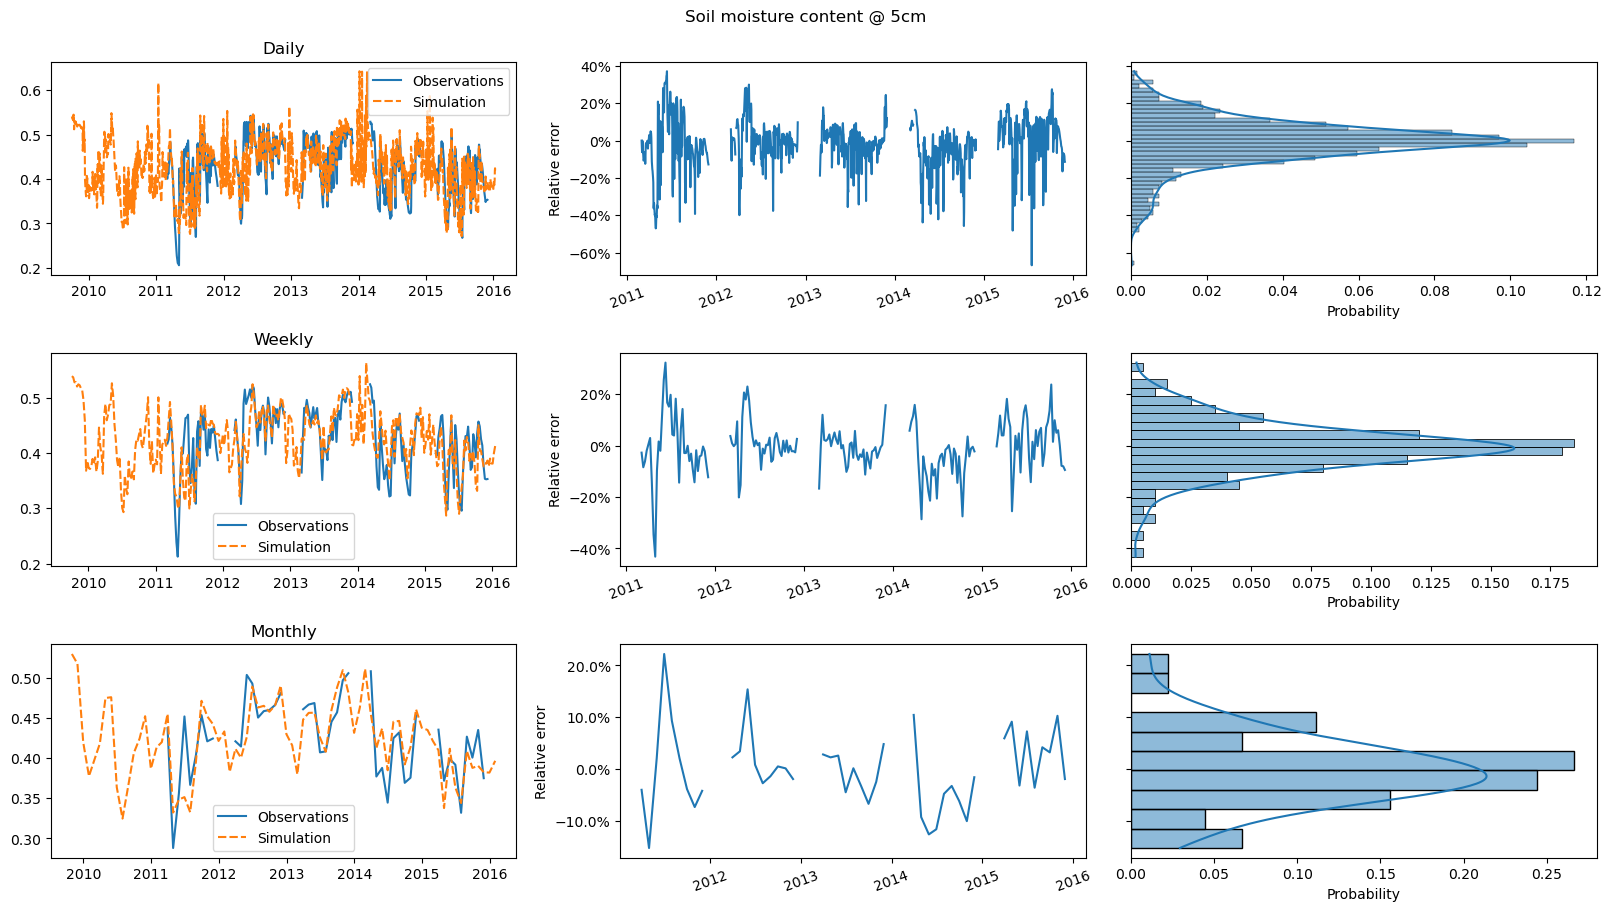

In [8]:
simulation = model(**recommendation)
print(f"After optimization loss is {measure(simulation)}")
comparison_plot(observations,
                simulation,
                desc='Soil moisture content @ 5cm',
                rel=True)
plt.show()

In [9]:
calibration.to_dataframe(recommendation)

lower  upper          best
NormalHydrConductivity  1.000000e-05  1.000  9.926435e-01
ThetaRes                0.000000e+00  1.000  2.517371e-01
WiltingPoint            0.000000e+00  1.000  1.568384e-01
FieldCapacity           0.000000e+00  1.000  4.897694e-01
ThetaSat                0.000000e+00  1.000  7.333460e-01
NVanGenuchten           1.010000e+00  2.500  1.192932e+00
AlphaVanGenuchten       1.000000e-05  1.000  2.632451e-03
VMualem                 0.000000e+00  1.000  5.975599e-01
SpecificStorativity     1.000000e-10  0.001  2.452618e-08

In [10]:
logger.parallel_coordinate_plot()

<IPython.core.display.Javascript object>